In [1]:
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from src.vae_model import vae_model
from src.mapper_model import mapper_model
from src.util import plot_mesh_permarray

from pyeit import mesh


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2024-12-02 14:48:46.358581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733150926.372314  865880 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733150926.376540  865880 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 14:48:46.393281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1733150934.304395  865880 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

In [2]:
n_el = 16  # nb of electrodes
mesh_obj = mesh.create(n_el, h0=0.05)


In [3]:
def load_all_data():
    voltage_dict = {} 
    gamma_dict = {} 
    data_dirs = sorted(glob("data*/"))  

    for i, directory in enumerate(data_dirs):
        file_list = sorted(glob(f"{directory}*.npz"))  
        voltage_list = []
        gamma_list = []

        for file in file_list:
            tmp = np.load(file, allow_pickle=True)  
            voltage_list.append(tmp["v"])  
            gamma_list.append(tmp["gamma"])  

        voltage_array = np.array(voltage_list) / 150
        voltage_array = np.expand_dims(voltage_array, axis=2)
        gamma_array = np.array(gamma_list) / 150          #WARUM Normalisierung?
        gamma_array = np.expand_dims(gamma_array, axis=2)
        
        # Speichere das Array im Dictionary
        voltage_dict[f"voltage{i}" if i > 0 else "voltage"] = voltage_array
        gamma_dict[f"gamma{i}" if i > 0 else "gamma"] = gamma_array
    
    return voltage_dict, gamma_dict

# Daten laden
voltage_dict, gamma_dict = load_all_data()

# Zugriff auf die Daten
voltage4 = voltage_dict["voltage4"]
gamma4 = gamma_dict["gamma4"]



In [4]:
#EIT = voltage4.reshape(-1, 32, 32, 1)
#perm_array = perm_array.reshape(-1, 2840, 1)

In [5]:
gamma4.shape

(10000, 2821, 1)

In [6]:
mapper = mapper_model()
mapper.summary()

mapper.compile(Adam(), loss="mse")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,736 (100.53 KB)

 Trainable params: 25,736 (100.53 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
vae = vae_model()  
vae.build(input_shape=(None, *gamma4.shape[1:])) 
vae.load_weights("weights/vae.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [8]:
#gamma_train, gamma_test = train_test_split(gamma4, test_size=0.2, random_state=42)

z_mean, z_log_var, z = vae.encoder.predict(gamma4)
#gamma_hat = vae.decoder.predict(z) * 150
#for idx in np.random.randint(0, high=gamma4.shape[0], size=5):
    #plot_mesh_permarray(mesh_obj, gamma4[idx,:,0], title = "True")
    #plot_mesh_permarray(mesh_obj, gamma_hat[idx, :, 0], title="Pred")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [9]:
#print(voltage4)

In [10]:
(v_train, v_test, gamma_train, gamma_test, z_train, z_test) = train_test_split(voltage4,gamma4,z,test_size=0.1,shuffle=False,random_state=42)
v_train.shape, z.shape

((9000, 192, 1), (10000, 8))

In [14]:
history_mapper = mapper.fit(
    v_train,  
    z_train,  
    epochs=200, 
    batch_size=8, 
    validation_data=(v_test, z_test)  
)

Epoch 1/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - loss: 0.9438 - val_loss: 0.8263
Epoch 2/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.9503 - val_loss: 0.8257
Epoch 3/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - loss: 0.9458 - val_loss: 0.8257
Epoch 4/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - loss: 0.9441 - val_loss: 0.8257
Epoch 5/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 0.9561 - val_loss: 0.8257
Epoch 6/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - loss: 0.9506 - val_loss: 0.8257
Epoch 7/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 0.9477 - val_loss: 0.8258
Epoch 8/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - loss: 0.9445 - val_loss: 0.8257
Epoch 9/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 0.9509 - val_loss: 0.8257
Epoch 10/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - loss: 0.9479 - val_loss: 0.8274
Epoch 11/200
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.9448 - val_loss: 0.82

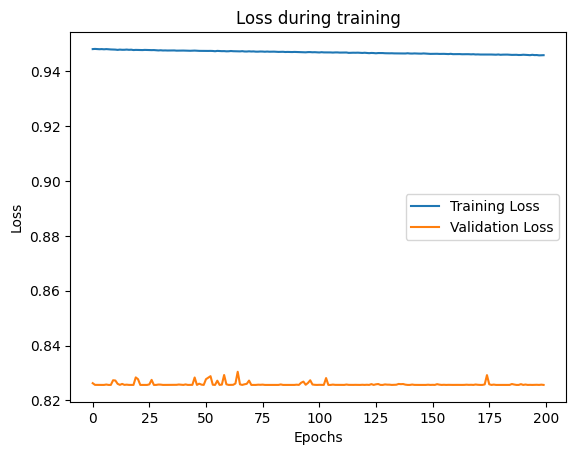

In [17]:
plt.plot(history_mapper.history['loss'], label='Training Loss')  # Training Loss
plt.plot(history_mapper.history['val_loss'], label='Validation Loss')  # Validation Loss
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


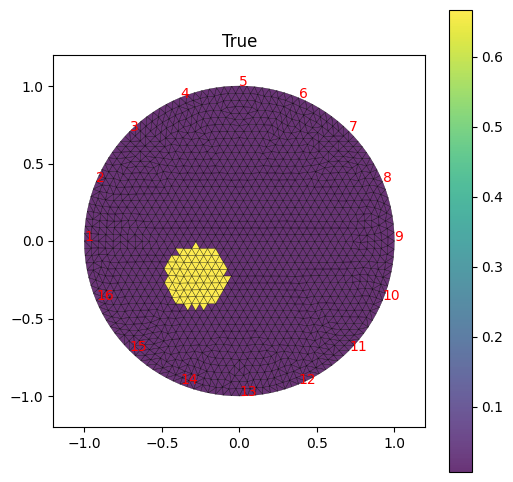

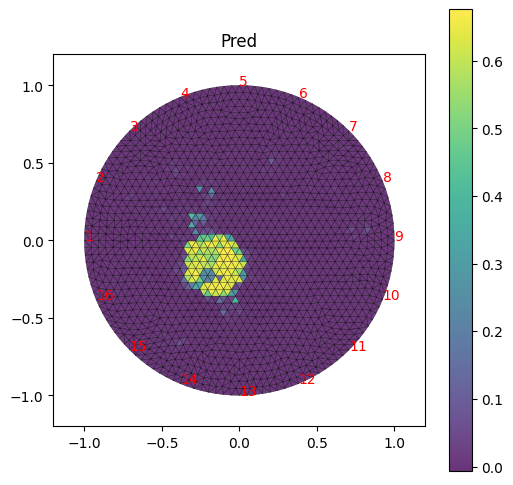

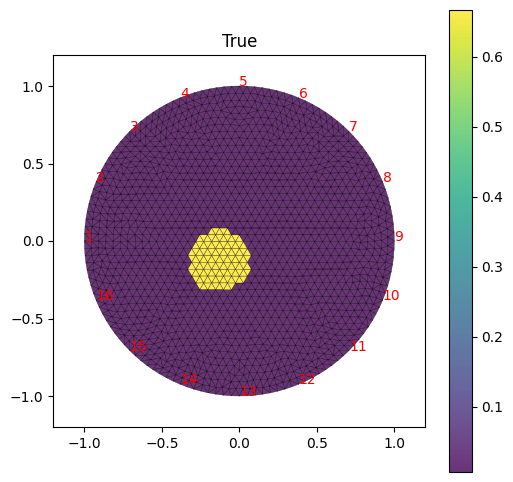

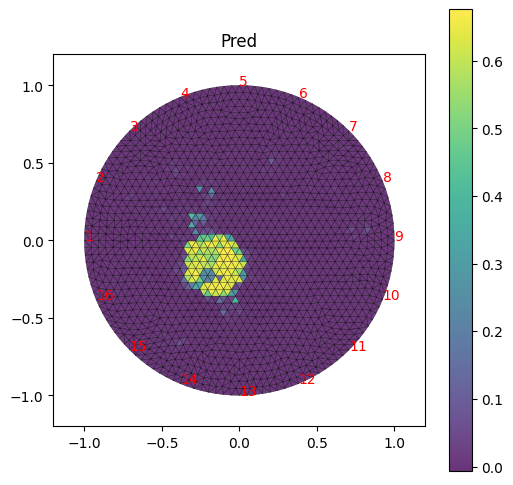

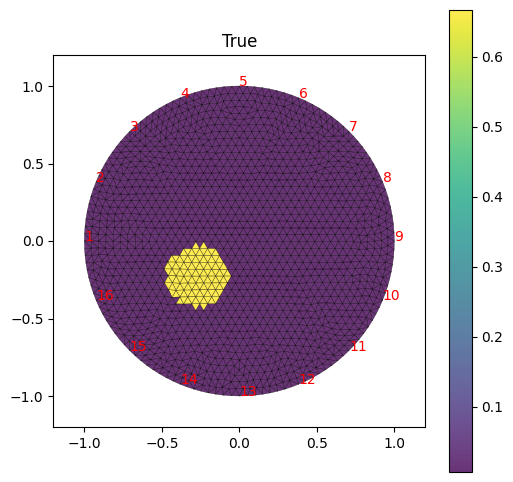

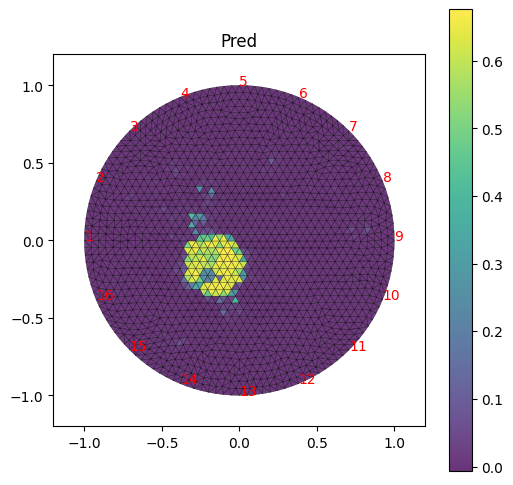

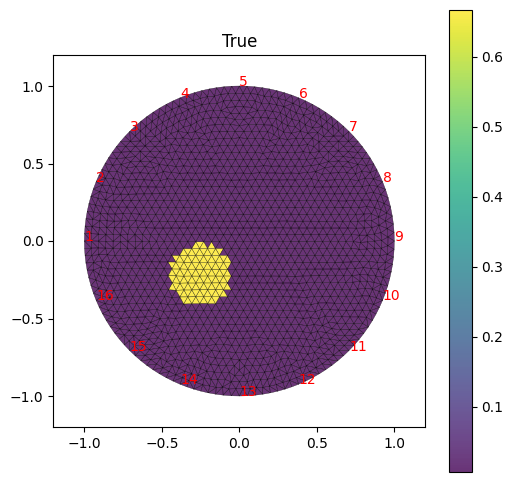

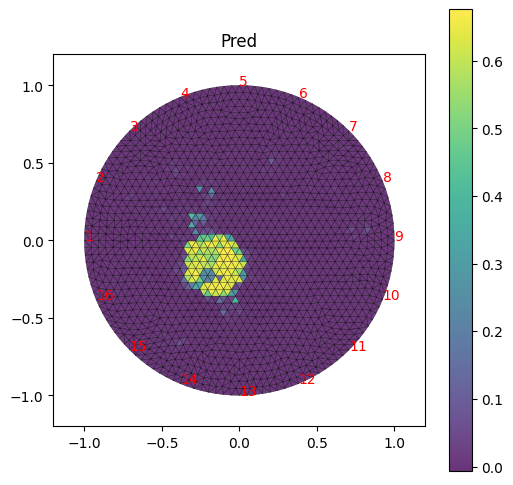

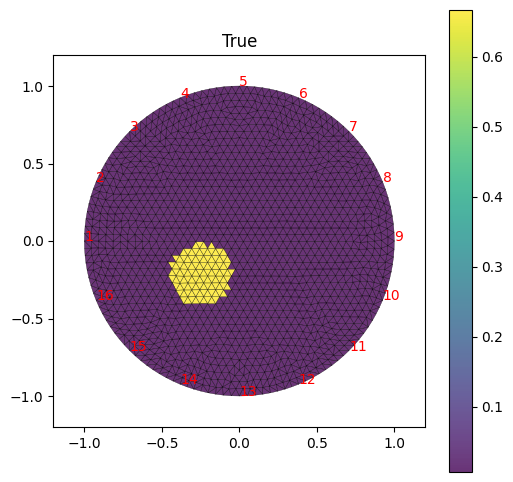

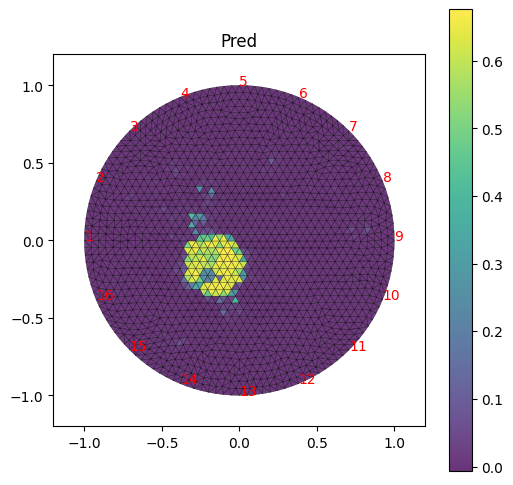

In [16]:
def reconstruct_from_voltage(voltage_input):
    z_hat = mapper.predict(voltage_input)
    gamma_hat = vae.decoder.predict(z_hat)
    return gamma_hat, z_hat

gamma_hat, z_hat = reconstruct_from_voltage(v_test)

for idx in np.random.randint(0, high=gamma_test.shape[0], size=5):
    plot_mesh_permarray(mesh_obj, gamma_test[idx, :, 0], title="True")
    
    plot_mesh_permarray(mesh_obj, gamma_hat[idx, :, 0], title="Pred")
